In [22]:
import xgboost as xgb
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

ratio=2

signal = pd.read_pickle(str(ratio)+'to1Signal.pkl')
bkgnd = pd.read_pickle(str(ratio)+'to1Background.pkl')

In [23]:
signal = signal[['Bpt' ,'kpt' ,'PDL' ,'prob' ,'cosA' ,'signLxy']]
bkgnd = bkgnd[['Bpt' ,'kpt' ,'PDL' ,'prob' ,'cosA' ,'signLxy']]

In [24]:
bkgnd['signal/bkgnd'] = 0
signal['signal/bkgnd'] = 1

In [25]:
df = pd.concat([signal,bkgnd])

In [26]:
#GENERAL DATA
train_x = df.drop(['signal/bkgnd'], axis=1) #features = all minus (signal/bkgnd and masses)
train_y = df['signal/bkgnd'] #label = signal/bkgnd

#SIGNAL
signal_x = signal.drop(['signal/bkgnd'], axis=1)
signal_y = signal['signal/bkgnd']

#BKGND
bkgnd_x = bkgnd.drop(['signal/bkgnd'], axis=1)
bkgnd_y = bkgnd['signal/bkgnd']

In [27]:
#SAMPLING DATA
#GENERAL
#train_x, test_x, train_y, test_y = train_test_split(train_x, train_y, 
 #                                                test_size=0.5, 
  #                                               random_state=1)

#SIGNAL
train_signal_x, test_signal_x, train_signal_y, test_signal_y = train_test_split(signal_x, signal_y, 
                                                  test_size=0.5, 
                                                  random_state=1)
#BKGND
train_bkgnd_x, test_bkgnd_x, train_bkgnd_y, test_bkgnd_y = train_test_split(bkgnd_x, bkgnd_y, 
                                                  test_size=0.5, 
                                                  random_state=1)

In [28]:
test_x = test_signal_x.append(test_bkgnd_x)
test_y = test_signal_y.append(test_bkgnd_y)

In [29]:
train_x = train_signal_x.append(train_bkgnd_x)
train_y = train_signal_y.append(train_bkgnd_y)

In [30]:
#XGBClassifier scikit-learn API 
model = xgb.XGBClassifier(objective = 'binary:logistic', max_depth=3, learning_rate=0.1)
#fit = training
model.fit(train_x, train_y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [31]:
predict_signal = model.predict(test_x)
print(np.round(accuracy_score(test_y,predict_signal)*100, 2),'%')

95.1 %


In [32]:
#applying the model to test and training
predict_signal_test =  model.predict_proba(test_signal_x)[:,1]
predict_signal_train =  model.predict_proba(train_signal_x)[:,1]

predict_back_test = model.predict_proba(test_bkgnd_x)[:,1]
predict_back_train = model.predict_proba(train_bkgnd_x)[:,1]

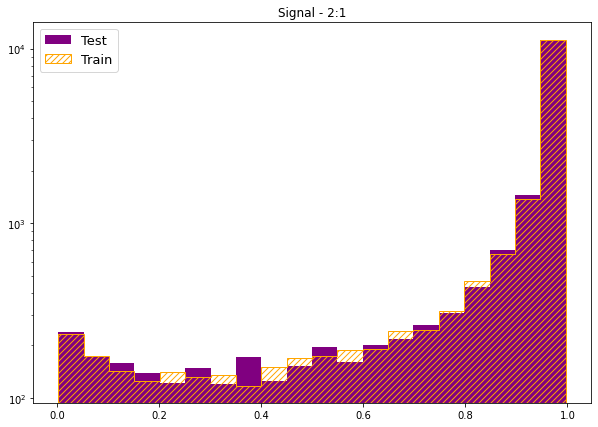

In [33]:
plt.figure(figsize=(10,7))
plt.title('Signal - '+str(ratio)+':1')
m = plt.hist(predict_signal_test, bins=20, label='Test', color='purple')
plt.hist(predict_signal_train, bins=m[1], label='Train', 
         histtype='stepfilled', facecolor='none', edgecolor='orange',
        hatch='////')
plt.legend(fontsize=13)
plt.yscale('log')
#plt.savefig('md6/'+str(ratio)+'to1Signal.png')
plt.show()

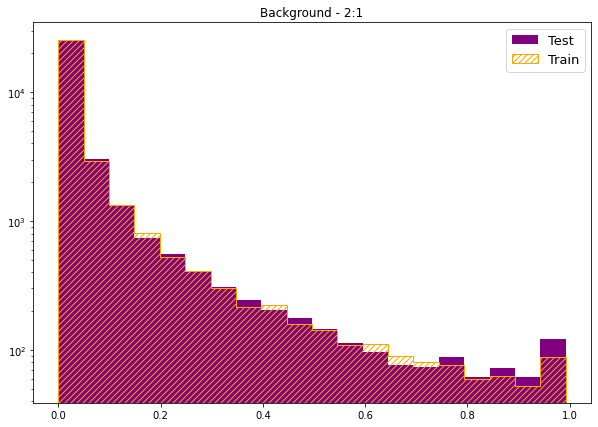

In [34]:
plt.figure(figsize=(10,7))
plt.title('Background - '+str(ratio)+':1')
m = plt.hist(predict_back_test, bins=20, label='Test', color='purple',)
plt.hist(predict_back_train, bins=m[1], label='Train', 
         histtype='stepfilled', facecolor='none', edgecolor='orange',
        hatch='////')
plt.legend(fontsize=13)
plt.yscale('log')
#plt.savefig('md6/'+str(ratio)+'to1Back.png')
plt.show()

Test :  0.98514345456776
Train :  0.986250808145907


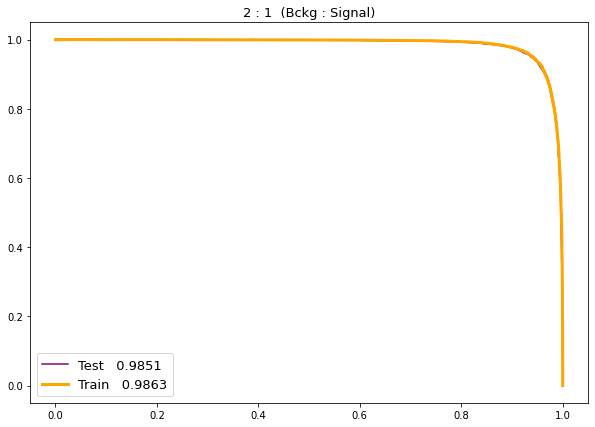

In [35]:
plt.figure(figsize=(10,7))
plt.title(str(ratio)+' : 1  (Bckg : Signal)', fontsize=13)
model_predict = model.predict_proba(test_x)
model_predict = model_predict[:,1]
auc_score = roc_auc_score(test_y, model_predict)
fpr, tpr, _ = roc_curve(test_y, model_predict)
print('Test : ', auc_score)
plt.plot(tpr, 1-fpr, label='Test   '+ str(round(auc_score, 4)), color='purple')
model_predict = model.predict_proba(train_x)
model_predict = model_predict[:,1]
auc_score = roc_auc_score(train_y, model_predict)
fpr, tpr, _ = roc_curve(train_y, model_predict)
plt.plot(tpr, 1-fpr, label='Train   ' + str(round(auc_score,4)) , color='orange', linewidth=3)
print('Train : ', auc_score)
plt.legend(fontsize=13)
#plt.savefig('md6/'+str(ratio)+'to1roc.png')
plt.show()

max_depth=6,4,3,2
learning_rate=0.3, 0.1, 0.01, 0.001

max_depth fixed to 6


test      train
(0.9868215746427537, 0.9987899188594205)
0.9867863316532909, 0.9954225971379359
0.9763512095002719, 0.9797037451936672
0.9693657029825964, 0.9713722958564757



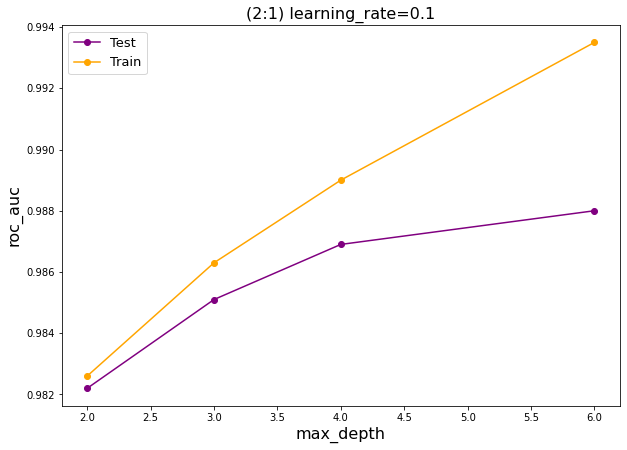

In [36]:
plt.figure(figsize=(10,7))
plt.title('(2:1) learning_rate=0.1', fontsize=16)
maxdepth = [2,3,4,6]
rocau_test = [0.9822,0.9851,0.9869,0.9880]
rocau_train = [0.9826,0.9863,0.9890,0.9935]
plt.plot(maxdepth,rocau_test,'-o', color='purple', label='Test')
plt.plot(maxdepth,rocau_train,'-o', color='orange', label='Train')
plt.xlabel('max_depth', fontsize=16)
plt.ylabel('roc_auc', fontsize=16)
plt.legend(fontsize=13)
#plt.savefig('newplt/2-1rocvsmax.png')
plt.show()

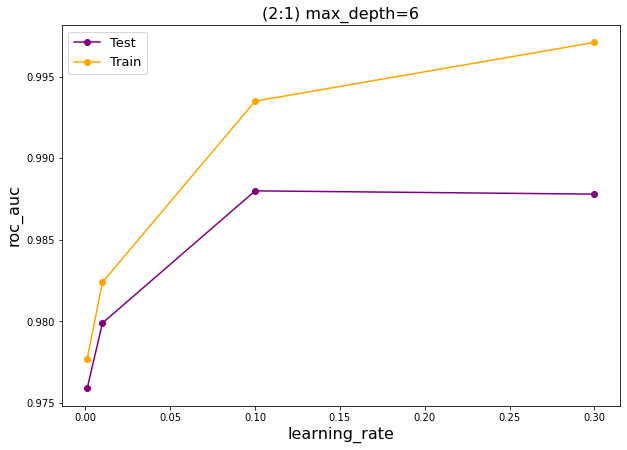

In [37]:
plt.figure(figsize=(10,7))
plt.title('(2:1) max_depth=6', fontsize=16)
lrate = [0.001,0.01,0.1,0.3]
rocau_test = [0.9759,0.9799,0.9880,0.9878]
rocau_train = [0.9777,0.9824,0.9935,0.9971]
plt.plot(lrate,rocau_test,'-o', color='purple', label='Test')
plt.plot(lrate,rocau_train,'-o', color='orange', label='Train')
plt.xlabel('learning_rate', fontsize=16)
plt.ylabel('roc_auc', fontsize=16)
plt.legend(fontsize=13)
#plt.savefig('newplt/2-1rocvslr.png')
plt.show()

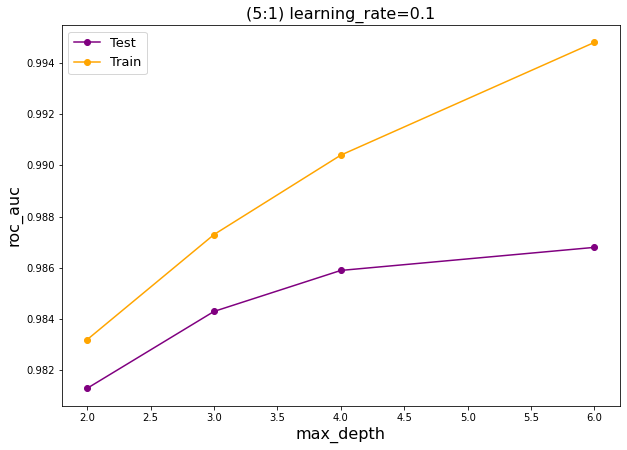

In [38]:
plt.figure(figsize=(10,7))
plt.title('(5:1) learning_rate=0.1', fontsize=16)
maxdepth = [2,3,4,6]
rocau_test = [0.9813,0.9843,0.9859,0.9868]
rocau_train = [0.9832,0.9873,0.9904,0.9948]
plt.plot(maxdepth,rocau_test,'-o', color='purple', label='Test')
plt.plot(maxdepth,rocau_train,'-o', color='orange', label='Train')
plt.xlabel('max_depth', fontsize=16)
plt.ylabel('roc_auc', fontsize=16)
plt.legend(fontsize=13)
#plt.savefig('newplt/5-1rocvsmax.png')
plt.show()

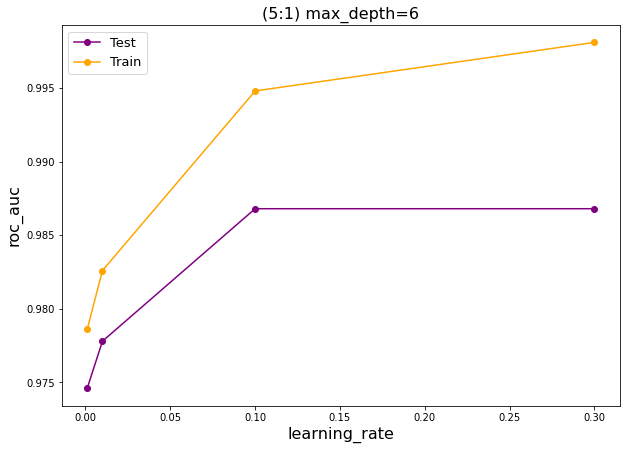

In [39]:
plt.figure(figsize=(10,7))
plt.title('(5:1) max_depth=6', fontsize=16)
lrate = [0.001,0.01,0.1,0.3]
rocau_test = [0.9746,0.9778,0.9868,0.9868]
rocau_train = [0.9786,0.9826,0.9948,0.9981]
plt.plot(lrate,rocau_test,'-o', color='purple', label='Test')
plt.plot(lrate,rocau_train,'-o', color='orange', label='Train')
plt.xlabel('learning_rate', fontsize=16)
plt.ylabel('roc_auc', fontsize=16)
plt.legend(fontsize=13)
#plt.savefig('newplt/5-1rocvslr.png')
plt.show()

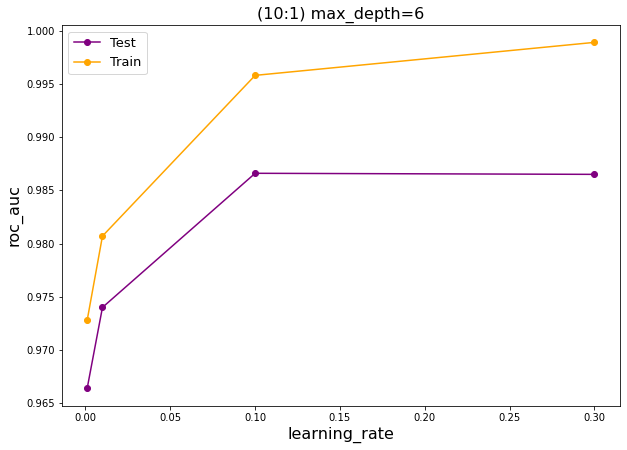

In [40]:
plt.figure(figsize=(10,7))
plt.title('(10:1) max_depth=6', fontsize=16)
lrate = [0.001,0.01,0.1,0.3]
rocau_test = [0.9664,0.9740,0.9866,0.9865]
rocau_train = [0.9728,0.9807,0.9958,0.9989]
plt.plot(lrate,rocau_test,'-o', color='purple', label='Test')
plt.plot(lrate,rocau_train,'-o', color='orange', label='Train')
plt.xlabel('learning_rate', fontsize=16)
plt.ylabel('roc_auc', fontsize=16)
plt.legend(fontsize=13)
#plt.savefig('newplt/10-1rocvslr.png')
plt.show()

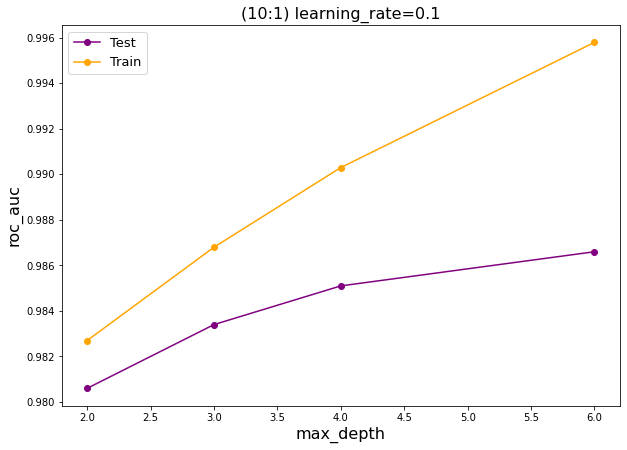

In [41]:
plt.figure(figsize=(10,7))
plt.title('(10:1) learning_rate=0.1', fontsize=16)
maxdepth = [2,3,4,6]
rocau_test = [0.9806,0.9834,0.9851,0.9866]
rocau_train = [0.9827,0.9868,0.9903,0.9958]
plt.plot(maxdepth,rocau_test,'-o', color='purple', label='Test')
plt.plot(maxdepth,rocau_train,'-o', color='orange', label='Train')
plt.xlabel('max_depth', fontsize=16)
plt.ylabel('roc_auc', fontsize=16)
plt.legend(fontsize=13)
#plt.savefig('newplt/10-1rocvsmax.png')
plt.show()